In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [13]:
df = pd.read_csv('server/data-12-22-18.csv')
df['correct'] = (df.true == df.pred)
df['(true=1,pred=1)'] = (df.true == 1) &  (df.pred == 1)
df['(true=1,pred=0)'] = (df.true == 1) &  (df.pred == 0)
df['(true=0,pred=1)'] = (df.true == 0) &  (df.pred == 1)
df['(true=0,pred=0)'] = (df.true == 0) &  (df.pred == 0)
df = df[df.gender.isin(['male', 'female'])]

df[:10]

,id,uid,expt_id,duration,true,pred,age,gender,expert,filename,correct,"(true=1,pred=1)","(true=1,pred=0)","(true=0,pred=1)","(true=0,pred=0)"
0,1,df28d326ca098ebc03e58dbfbf256259,2,1000,1,0,18,male,0,real-blur/real-blur-41.jpg,False,False,True,False,False
1,2,df28d326ca098ebc03e58dbfbf256259,2,1000,0,0,18,male,0,gan-blur/gan-blur-9.jpg,True,False,False,False,True
2,3,df28d326ca098ebc03e58dbfbf256259,2,1000,1,1,18,male,0,real-blur/real-blur-6.jpg,True,True,False,False,False
3,4,df28d326ca098ebc03e58dbfbf256259,2,1000,0,0,18,male,0,gan-blur/gan-blur-31.jpg,True,False,False,False,True
4,5,df28d326ca098ebc03e58dbfbf256259,2,1000,1,1,18,male,0,real-blur/real-blur-27.jpg,True,True,False,False,False
5,6,df28d326ca098ebc03e58dbfbf256259,2,1000,0,0,18,male,0,gan-blur/gan-blur-39.jpg,True,False,False,False,True
6,7,df28d326ca098ebc03e58dbfbf256259,2,250,0,0,18,male,0,gan-blur/gan-blur-36.jpg,True,False,False,False,True
7,8,df28d326ca098ebc03e58dbfbf256259,2,250,0,1,18,male,0,gan-blur/gan-blur-3.jpg,False,False,False,True,False
8,9,df28d326ca098ebc03e58dbfbf256259,2,250,1,1,18,male,0,real-blur/real-blur-5.jpg,True,True,False,False,False
9,10,df28d326ca098ebc03e58dbfbf256259,2,250,0,0,18,male,0,gan-blur/gan-blur-28.jpg,True,False,False,False,True


In [15]:
print ("Exp 1 datapoints: %d" % df[df.expt_id==1].id.count())
print ("Exp 2 datapoints: %d" % df[df.expt_id==2].id.count())
print ("users: %d" % df.uid.nunique())
print ("experts: %d, non-experts: %d" % (df[df.expert==1].uid.nunique(), df[df.expert==0].uid.nunique()))
print ("men: %d, women: %d" % (df[df.gender=='male'].uid.nunique(), df[df.gender=='female'].uid.nunique()))
print ("---------------------------------------------")
print(df[df.gender != 'other'].groupby(["expt_id", "duration"]).id.count().reset_index().sort_values(by=['expt_id','duration'], ascending=[True,False]))
print(df[df.gender != 'other'].groupby(["expt_id", "duration", "gender"]).id.count().reset_index().sort_values(by=['expt_id','duration'], ascending=[True,False]))

Exp 1 datapoints: 3744
Exp 2 datapoints: 4020
users: 317
experts: 136, non-experts: 181
men: 280, women: 37
---------------------------------------------
   expt_id  duration   id
4        1      5000  714
3        1      2000  762
2        1      1000  732
1        1       500  768
0        1       250  768
9        2      5000  810
8        2      2000  792
7        2      1000  810
6        2       500  774
5        2       250  834
    expt_id  duration  gender   id
8         1      5000  female  102
9         1      5000    male  612
6         1      2000  female  120
7         1      2000    male  642
4         1      1000  female  102
5         1      1000    male  630
2         1       500  female  108
3         1       500    male  660
0         1       250  female  108
1         1       250    male  660
18        2      5000  female   72
19        2      5000    male  738
16        2      2000  female   90
17        2      2000    male  702
14        2      1000  female   96


In [16]:
expt_id1 = 1
expt_id2 = 1
dur1 = 5000
dur2 = 5000
g1 = 'male'
g2 = 'female'
e1 = True
e2 = True

exp1_data = df[(df.expt_id==expt_id1) & (df.duration==dur1) & (df.gender==g1) & (df.expert==e1)].correct
exp2_data = df[(df.expt_id==expt_id2) & (df.duration==dur2) & (df.gender==g2) & (df.expert==e2)].correct

print (exp1_data.mean())
print (exp2_data.mean())


from scipy.stats import ttest_ind

print (ttest_ind(exp1_data, exp2_data))

0.7264150943396226
0.6666666666666666
Ttest_indResult(statistic=0.6961774441505297, pvalue=0.48678509269024983)


In [17]:
def conf_interval(N, p_success):
    return (1.96/N)*np.sqrt(p_success*(1-p_success)*N) #95% conf interval


def get_results(df, columns):
    results = df.groupby(columns).agg({
        'uid': 'nunique',
        'id': 'nunique',
        'true': 'sum',
        'correct': 'sum',
        '(true=1,pred=1)': 'sum',
        '(true=0,pred=1)':'sum',
        '(true=1,pred=0)': 'sum',
        '(true=0,pred=0)': 'sum',
    }).reset_index()
    
    results['accuracy'] = results.correct / results.id   
    results['accuracy_conf'] = conf_interval(results.id, results.accuracy)
    
    results['(pred=1|true=1)'] = results['(true=1,pred=1)'] / results.true
    results['(pred=0|true=1)'] = results['(true=1,pred=0)'] / results.true
    results['(pred=1|true=0)'] = results['(true=0,pred=1)'] / (results.id - results.true)
    results['(pred=0|true=0)'] = results['(true=0,pred=0)'] / (results.id - results.true)

    results['(pred=1|true=1)_conf'] = conf_interval(results.true, results['(pred=1|true=1)'])
    results['(pred=0|true=1)_conf'] = conf_interval(results.true, results['(pred=0|true=1)'])
    results['(pred=1|true=0)_conf'] = conf_interval(results.id-results.true, results['(pred=1|true=0)'])
    results['(pred=0|true=0)_conf'] = conf_interval(results.id-results.true, results['(pred=0|true=0)'])

    return results

results = get_results(df, ['expt_id', 'duration'])
expert_results = get_results(df, ['expt_id', 'duration', 'expert'])
gender_results = get_results(df, ['expt_id', 'duration', 'gender'])
expert_gender_results = get_results(df, ['expt_id', 'duration', 'expert', 'gender'])

results

,expt_id,duration,uid,id,true,correct,"(true=1,pred=1)","(true=0,pred=1)","(true=1,pred=0)","(true=0,pred=0)",accuracy,accuracy_conf,(pred=1|true=1),(pred=0|true=1),(pred=1|true=0),(pred=0|true=0),(pred=1|true=1)_conf,(pred=0|true=1)_conf,(pred=1|true=0)_conf,(pred=0|true=0)_conf
0,1,250,128,768,390,420.0,231.0,189.0,159.0,189.0,0.546875,0.035207,0.592308,0.407692,0.500000,0.500000,0.048771,0.048771,0.050406,0.050406
1,1,500,128,768,387,475.0,233.0,139.0,154.0,242.0,0.618490,0.034355,0.602067,0.397933,0.364829,0.635171,0.048767,0.048767,0.048337,0.048337
2,1,1000,122,732,382,491.0,238.0,97.0,144.0,253.0,0.670765,0.034044,0.623037,0.376963,0.277143,0.722857,0.048599,0.048599,0.046892,0.046892
3,1,2000,127,762,376,524.0,252.0,114.0,124.0,272.0,0.687664,0.032906,0.670213,0.329787,0.295337,0.704663,0.047521,0.047521,0.045511,0.045511
4,1,5000,119,714,345,490.0,227.0,106.0,118.0,263.0,0.686275,0.034035,0.657971,0.342029,0.287263,0.712737,0.050059,0.050059,0.046169,0.046169
5,2,250,138,834,425,476.0,245.0,178.0,180.0,231.0,0.570743,0.033593,0.576471,0.423529,0.435208,0.564792,0.046978,0.046978,0.048049,0.048049
6,2,500,129,774,394,419.0,206.0,167.0,188.0,213.0,0.541344,0.035105,0.522843,0.477157,0.439474,0.560526,0.049320,0.049320,0.049903,0.049903
7,2,1000,134,810,404,494.0,228.0,140.0,176.0,266.0,0.609877,0.033592,0.564356,0.435644,0.344828,0.655172,0.048351,0.048351,0.046235,0.046235
8,2,2000,132,792,380,516.0,228.0,124.0,152.0,288.0,0.651515,0.033185,0.600000,0.400000,0.300971,0.699029,0.049257,0.049257,0.044291,0.044291
9,2,5000,134,810,425,541.0,266.0,110.0,159.0,275.0,0.667901,0.032434,0.625882,0.374118,0.285714,0.714286,0.046006,0.046006,0.045126,0.045126


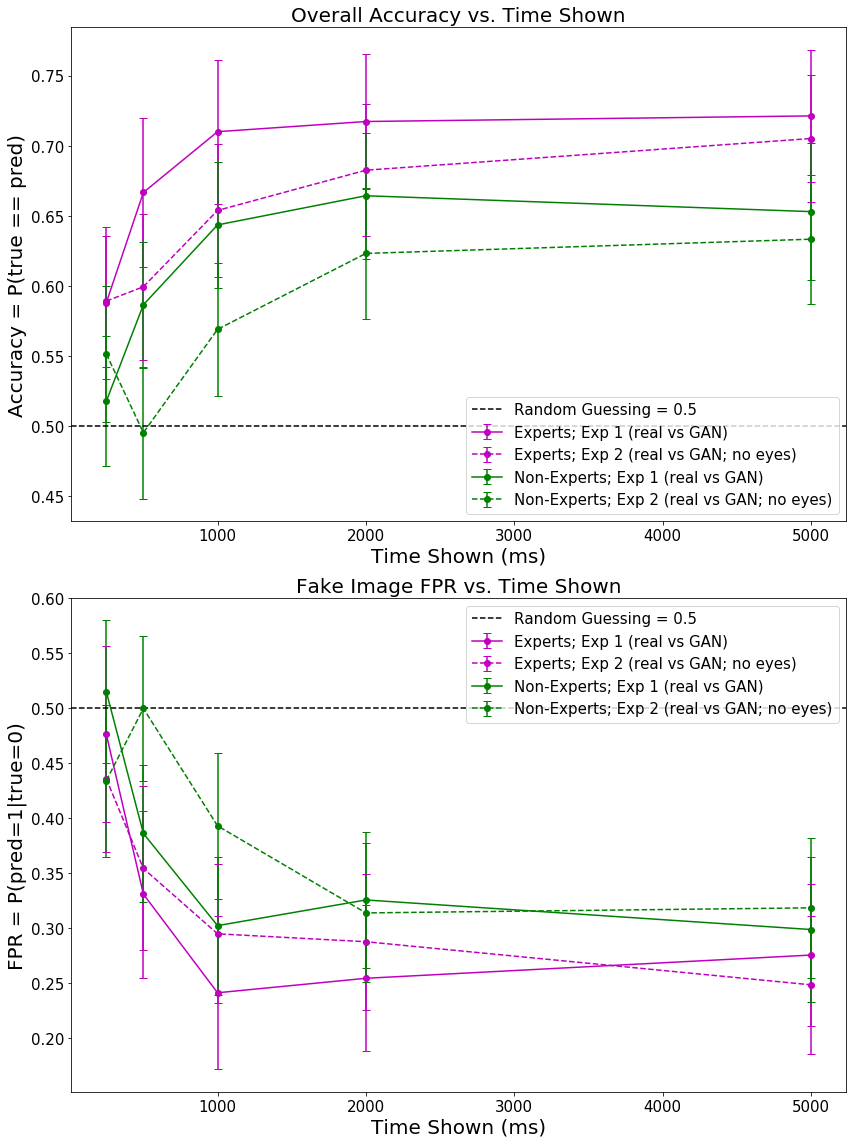

In [18]:
fig = plt.figure(figsize=(12,16))
fs = 20
tfs = 15

ax1 = fig.add_subplot(211)
ax1.set_title("Overall Accuracy vs. Time Shown", fontsize=fs)
ax1.set_xlabel("Time Shown (ms)", fontsize=fs)
ax1.set_ylabel("Accuracy = P(true == pred)", fontsize=fs)
ax2 = fig.add_subplot(212)
ax2.set_title("Fake Image FPR vs. Time Shown", fontsize=fs)
ax2.set_xlabel("Time Shown (ms)", fontsize=fs)
ax2.set_ylabel("FPR = P(pred=1|true=0)", fontsize=fs)

id_map = [
    (1, "Experts; Exp 1 (real vs GAN)", "m", "-", True), 
    (2, "Experts; Exp 2 (real vs GAN; no eyes)", "m", "--", True),
    (1, "Non-Experts; Exp 1 (real vs GAN)", "g", "-", False), 
    (2, "Non-Experts; Exp 2 (real vs GAN; no eyes)", "g", "--", False)
]

for (expt_id, label, color, linestyle, expert)  in id_map:
    exp_data = expert_results[(expert_results.expt_id == expt_id) & (expert_results.expert == expert)]
    ax1.errorbar(exp_data.duration, exp_data['accuracy'], yerr=exp_data['accuracy_conf'],
                 color=color, linestyle=linestyle, marker='o', label=label, capsize=4)
    ax2.errorbar(exp_data.duration, exp_data['(pred=1|true=0)'], yerr=exp_data['(pred=1|true=0)_conf'],
                 color=color, linestyle=linestyle, marker='o', label=label, capsize=4)

ax1.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")
ax1.legend(loc=0, fontsize=tfs)
ax1.xaxis.set_tick_params(labelsize=tfs)
ax1.yaxis.set_tick_params(labelsize=tfs)

ax2.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")
ax2.legend(loc=0, fontsize=tfs)
ax2.xaxis.set_tick_params(labelsize=tfs)
ax2.yaxis.set_tick_params(labelsize=tfs)

plt.tight_layout()
plt.show()

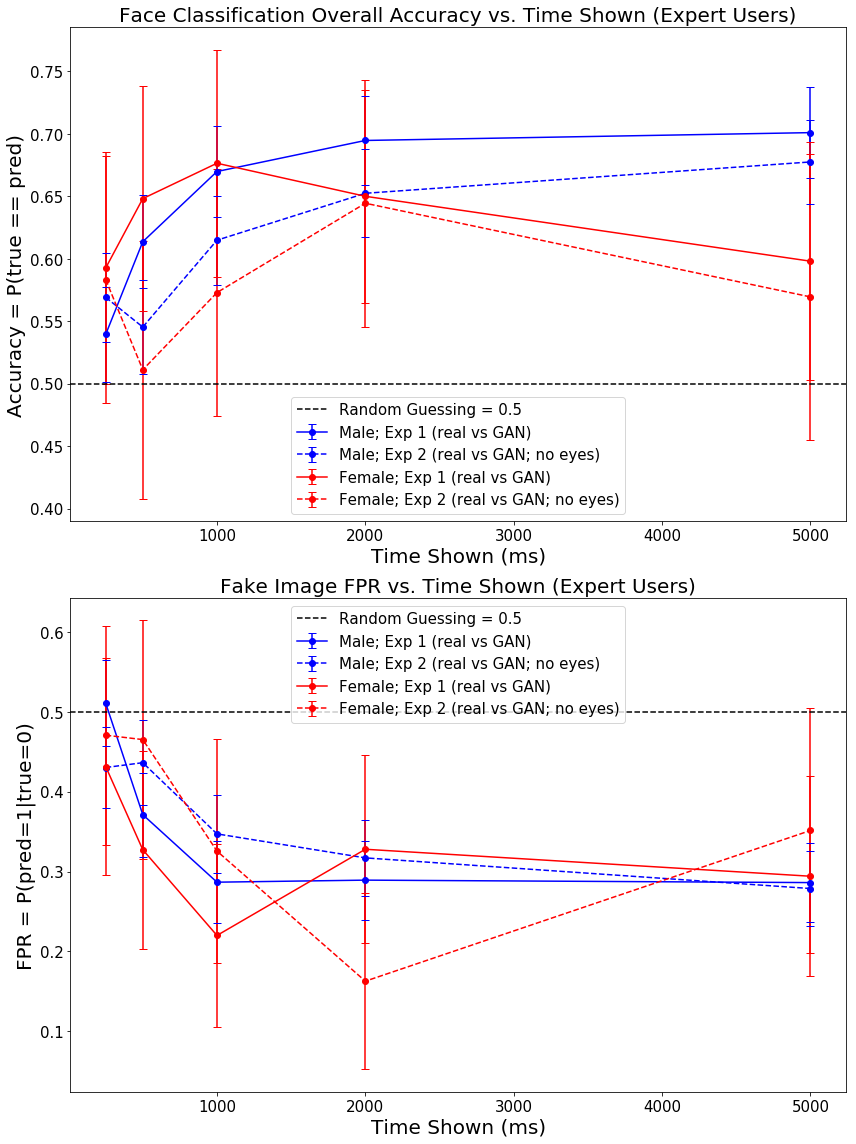

In [19]:
fs = 20
tfs = 15

fig = plt.figure(figsize=(12,16))
ax1 = fig.add_subplot(211)
ax1.set_title("Face Classification Overall Accuracy vs. Time Shown (Expert Users)", fontsize=fs)
ax1.set_xlabel("Time Shown (ms)", fontsize=fs)
ax1.set_ylabel("Accuracy = P(true == pred)", fontsize=fs)
ax2 = fig.add_subplot(212)
ax2.set_title("Fake Image FPR vs. Time Shown (Expert Users)", fontsize=fs)
ax2.set_xlabel("Time Shown (ms)", fontsize=fs)
ax2.set_ylabel("FPR = P(pred=1|true=0)", fontsize=fs)

gender_id_map = {
    ('male', 1):("Male; Exp 1 (real vs GAN)", "b", "-"), 
    ('male', 2):("Male; Exp 2 (real vs GAN; no eyes)", "b", "--"),
    ('female', 1):("Female; Exp 1 (real vs GAN)", "r", "-"), 
    ('female', 2):("Female; Exp 2 (real vs GAN; no eyes)", "r", "--")
}

expert_filter = None

for (gender, expt_id), (label, color, linestyle)  in gender_id_map.items():
    if expert_filter is not None:
        exp_data = expert_gender_results[(expert_gender_results.expert == expert_filter) &
                                         (expert_gender_results.gender == gender) & 
                                         (expert_gender_results.expt_id == expt_id)]
    else:
        exp_data = gender_results[(gender_results.gender == gender) & 
                                  (gender_results.expt_id == expt_id)]
        
    ax1.errorbar(exp_data.duration, exp_data['accuracy'], yerr=exp_data['accuracy_conf'],
                 color=color, linestyle=linestyle, marker='o', label=label, capsize=4)
    ax2.errorbar(exp_data.duration, exp_data['(pred=1|true=0)'], yerr=exp_data['(pred=1|true=0)_conf'],
                 color=color, linestyle=linestyle, marker='o', label=label, capsize=4)


ax1.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")
ax1.legend(loc=0, fontsize=tfs)
ax1.xaxis.set_tick_params(labelsize=tfs)
ax1.yaxis.set_tick_params(labelsize=tfs)

ax2.axhline(y=0.5, color="k", linestyle="--", label="Random Guessing = 0.5")
ax2.legend(loc=0, fontsize=tfs)
ax2.xaxis.set_tick_params(labelsize=tfs)
ax2.yaxis.set_tick_params(labelsize=tfs)

plt.tight_layout()
plt.show()

In [20]:
img_df = df.groupby('filename').agg({
    'id': 'count',
    'expt_id':'max',
    'correct': 'sum',
    'true': 'max'
}).reset_index()
img_df['accuracy'] = img_df.correct / img_df.id


gender_img_df = df.groupby(['filename', 'gender']).agg({
    'id': 'count',
    'expt_id':'max',
    'correct': 'sum',
    'true': 'max'
}).reset_index()
gender_img_df['accuracy'] = gender_img_df.correct / gender_img_df.id

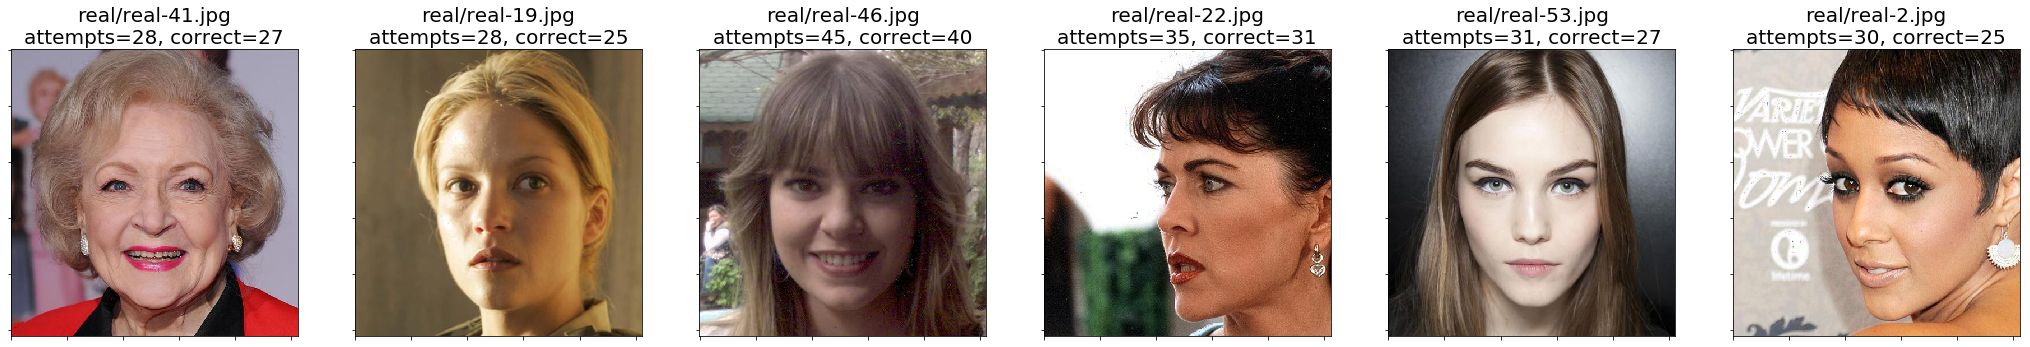

In [21]:
N = 6
expt_id = 1
true = 1
ascending = False

fs = 20

data = img_df[(img_df.true == true) & (img_df.expt_id == expt_id)].sort_values(by=['accuracy', 'id'], ascending=ascending).reset_index()

# plt.hist(data.accuracy, bins=10)
# plt.show()

fig = plt.figure(figsize=(36,6))
for i in range(N):
    ax = fig.add_subplot('%d%d%d' % (1,N,i+1))
    ax.set_title("%s\nattempts=%d, correct=%d" % (data.filename[i], data.id[i], int(data.correct[i])), fontsize=fs)
    filepath = os.path.join('./server/static', data.filename[i])
    ax.imshow(mpimg.imread(filepath))
    ax.set_yticklabels([])
    ax.set_xticklabels([])

# fig.savefig('./final_plots/easy_fake_exp1_expert.png')
plt.show()

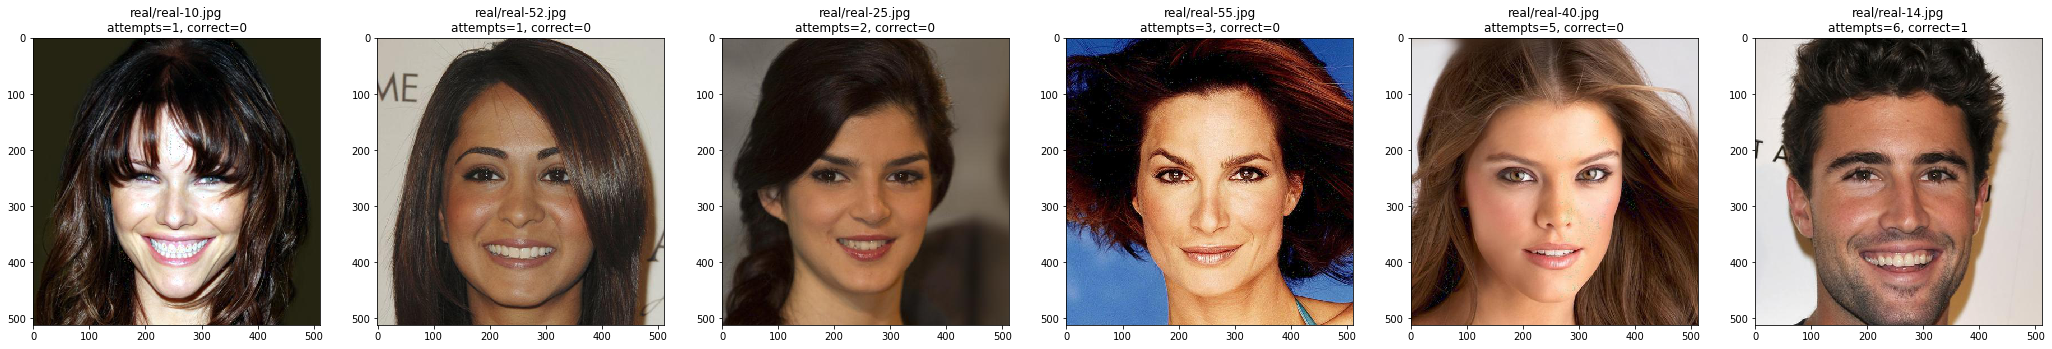

In [22]:
N = 6
true = 1
expt_id = 1
ascending = True
gender = 'female'

data = gender_img_df[(gender_img_df.true == true) & (gender_img_df.expt_id == expt_id) & (gender_img_df.gender == gender)].sort_values(by=['accuracy', 'id'], ascending=ascending).reset_index()

fig = plt.figure(figsize=(36,6))
for i in range(N):
    ax = fig.add_subplot('%d%d%d' % (1,N,i+1))
    ax.set_title("%s\nattempts=%d, correct=%d" % (data.filename[i], data.id[i], int(data.correct[i])))
    filepath = os.path.join('./server/static', data.filename[i])
    ax.imshow(mpimg.imread(filepath))

plt.show()

/home/abhinav/Documents/meng/venv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


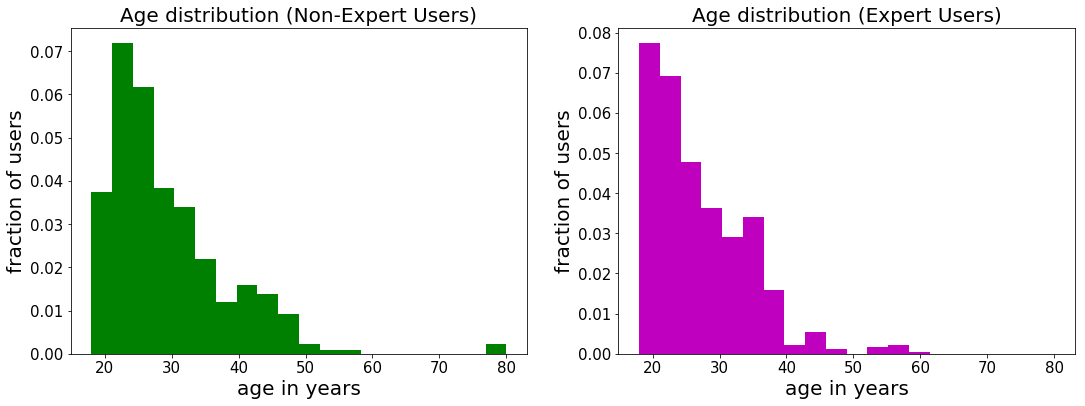

In [23]:
fs = 20
tfs = 15
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title("Age distribution (Non-Expert Users)", fontsize=fs)
ax2.set_title("Age distribution (Expert Users)", fontsize=fs)
ax1.set_xlabel("age in years", fontsize=fs)
ax2.set_xlabel("age in years", fontsize=fs)
ax1.set_ylabel("fraction of users", fontsize=fs)
ax2.set_ylabel("fraction of users", fontsize=fs)
ax1.hist(df[df.expert==0].age, bins=20, range=(18,80), color="g", normed=True)
ax2.hist(df[df.expert==1].age, bins=20, range=(18,80), color="m", normed=True)

ax1.xaxis.set_tick_params(labelsize=tfs)
ax1.yaxis.set_tick_params(labelsize=tfs)
ax2.xaxis.set_tick_params(labelsize=tfs)
ax2.yaxis.set_tick_params(labelsize=tfs)
plt.show()

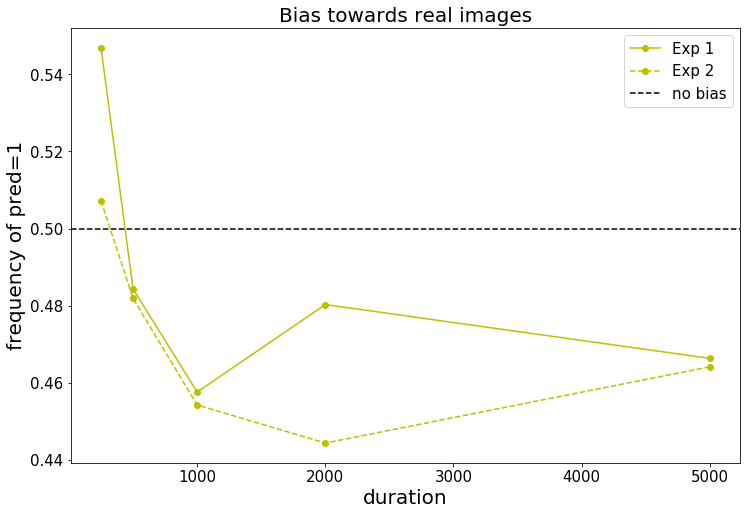

In [24]:
bias_df = df.groupby(['expt_id', 'duration']).pred.mean().reset_index()

fs = 20
tfs = 15

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for expt_id, style in [(1, '-'),(2, '--')]:
    data = bias_df[bias_df.expt_id == expt_id].sort_values(by="duration", ascending=True)
    ax.plot(data.duration, data.pred, color='y', marker="o", linestyle=style, label="Exp %d" % expt_id)
    
ax.axhline(y=0.5, color="k", linestyle="--", label="no bias")
ax.set_title("Bias towards real images", fontsize=fs)
ax.set_xlabel("duration", fontsize=fs)
ax.set_ylabel("frequency of pred=1", fontsize=fs)
ax.legend(loc=0, fontsize=tfs)
ax.xaxis.set_tick_params(labelsize=tfs)
ax.yaxis.set_tick_params(labelsize=tfs)

plt.show()    
